In [418]:
import sys
sys.path.append('../../')

from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils,
    constants,
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy import ndimage as ndi

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)
reload(constants)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [419]:
def make_exp_xarray(imgs, exp_id, imaging_scheme):
    lambdas_counts = pio.process_imaging_scheme_str(imaging_sscheme, "/")
    lambdas = np.array([l[0] for l in lambdas_counts])
    pairs = [l[1] for l in lambdas_counts]
    unique_lambdas = [lambdas[idx] for idx in sorted(np.unique(lambdas, return_index=True)[1])]
    n_animals = imgs.shape[0] // len(lambdas)
    img_height, img_width = imgs.shape[1], imgs.shape[2]
    
    tmp_img_stack = np.reshape()

In [420]:
meta_dir = Path('/Users/sean/code/pharynx_redox/data/paired_ratio')

all_ims_path = meta_dir.joinpath('all_seg_imgs.nc')

try:
    all_ims = xr.load_dataarray(all_ims_path)
except FileNotFoundError:
    all_ims = []
    for exp_dir in sorted(meta_dir.iterdir()):
        if not exp_dir.is_dir():
            continue
        logging.info(f'loading {exp_dir.stem}')
        img_path = list(exp_dir.glob('*.tif*'))[0]
        strain_map_path = list(exp_dir.glob('*-indexer.csv'))[0]
        strain_map = pio.load_strain_map_from_disk(strain_map_path)
        imgs = pio.load_images(img_path, "TL/470/410/470/410", strain_map)

        # set experiment-id to be the "strain"
        imgs['strain'] = np.repeat(exp_dir.stem, imgs.strain.shape[0])
    #     imgs = imgs.rename({'strain': 'experiment'})
        all_ims.append(imgs)

    all_ims = xr.concat(all_ims, 'strain')
    all_ims.to_netcdf('/Users/sean/code/pharynx_redox/data/paired_ratio/all_raw_imgs.nc')

In [421]:
seg_imgs_path = meta_dir.joinpath('all_seg_imgs.nc')
try:
    all_seg_ims = xr.load_dataarray(seg_imgs_path)
except FileNotFoundError:        
    all_seg_ims = ip.segment_pharynxes(all_ims)
    all_seg_ims.to_netcdf(seg_imgs_path)

In [422]:
rot_fl_path = meta_dir.joinpath('all_rot_fl.nc')
rot_seg_path = meta_dir.joinpath('all_rot_seg.nc')
try:
    all_rot_fl = xr.load_dataarray(rot_fl_path)
    all_rot_seg = xr.load_dataarray(rot_seg_path)
except:
    all_rot_fl, all_rot_seg = ip.center_and_rotate_pharynxes(all_ims, all_seg_ims)

    all_rot_fl.to_netcdf(rot_fl_path)
    all_rot_seg.to_netcdf(rot_seg_path)

In [423]:
midlines = ip.calculate_midlines(all_rot_seg)

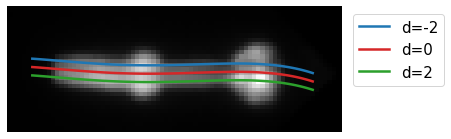

In [439]:
img_idx = 0
pair = 0
wvl = '410'
m_xs, m_ys = midlines[img_idx][wvl][pair].linspace()

# plt.figure(figsize=(20,10))

plt.imshow(all_rot_fl.sel(wavelength=wvl, pair=pair)[img_idx], cmap='gray')

lw = 2.5
plt.plot(m_xs, m_ys+2, label='d=-2', linewidth=lw);
plt.plot(m_xs, m_ys, label='d=0', color='tab:red', linewidth=lw);
plt.plot(m_xs, m_ys-2, label='d=2', color='tab:green', linewidth=lw);

plt.ylim(50,80);
plt.xlim(45, 125);
plt.axis('off');
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dY_shift.pdf', dpi=1200);
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dY_shift.png', dpi=300);

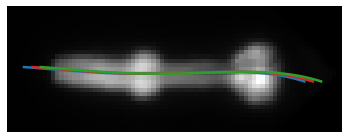

In [425]:
img_idx = 0
pair = 0
wvl = '410'
m_xs, m_ys = midlines[img_idx][wvl][pair].linspace()

# plt.figure(figsize=(20,10))

plt.imshow(all_rot_fl.sel(wavelength=wvl, pair=pair)[img_idx], cmap='gray')

lw = 2.5
plt.plot(m_xs-2, m_ys, label='dX=-2', linewidth=lw);
plt.plot(m_xs, m_ys, label='dX=0', color='tab:red', linewidth=lw);
plt.plot(m_xs+2, m_ys, label='dX=2', color='tab:green', linewidth=lw);

plt.ylim(50,80);
plt.xlim(45, 125);
plt.axis('off');
# plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dX_shift.pdf', dpi=1200);
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/dX_shift.png', dpi=300);

# Do the Shifting

In [447]:
ref_wvl = '410'
n_points = 150
i410 = []
i470 = []
R = []
dXs = []
dYs = []
pairs = []
exps = []

dX_shifts = np.arange(-2, 2.5, .5)
dY_shifts = np.arange(-2, 2.5, .5)

# filter out zeros
# dX_shifts = dX_shifts[np.nonzero(dX_shifts)]
# dY_shifts = dY_shifts[np.nonzero(dY_shifts)]

for img_idx in range(all_rot_fl.strain.size):    
    for pair in range(all_rot_fl.pair.size):
        m_xs, m_ys = midlines[img_idx]['410'][pair].linspace(n=n_points)
        im410 = all_rot_fl.sel(wavelength='410', pair=pair)[img_idx]
        im470 = all_rot_fl.sel(wavelength='410', pair=pair)[img_idx]
        
        dY = 0
        for dX in dX_shifts:
            i410_ = ndi.map_coordinates(im410, np.stack([m_ys, m_xs]), order=1)
            i470_ = ndi.map_coordinates(im470, np.stack([m_ys, m_xs + dX]), order=1)
            
            i410.append(i410_)
            i470.append(i470_)
            R.append(i410_ / i470_)
            pairs.append(pair)
            if pair == 0:
                dXs.append(dX)
                dYs.append(dY)
                exps.append(all_rot_fl.strain.values[img_idx])
        
        dX = 0
        for dY in dY_shifts:
            i410_ = ndi.map_coordinates(im410, np.stack([m_ys, m_xs]), order=1)
            i470_ = ndi.map_coordinates(im470, np.stack([m_ys + dY, m_xs]), order=1)
            
            i410.append(i410_)
            i470.append(i470_)
            R.append(i410_ / i470_)
            pairs.append(pair)
            if pair == 0:
                dXs.append(dX)
                dYs.append(dY)
                exps.append(all_rot_fl.strain.values[img_idx])
            
i410 = np.array(i410)
i470 = np.array(i470)
R = np.array(R)
pairs = np.array(pairs)

# Save into DataArray 

In [448]:
shift_idx = pd.MultiIndex.from_arrays([exps, dXs, dYs], names=('experiment', 'dx', 'dy'))


split_wvl = np.stack([i410, i470, R])
split_pair = np.stack([split_wvl[:, pairs==0, :], split_wvl[:, pairs==1, :]])

shift_data = xr.DataArray(
    split_pair,
    coords={
        'pair': [0, 1],
        'wavelength': ['410', '470', 'r'],
        'spec': shift_idx
    },
    dims=['pair', 'wavelength', 'spec', 'position']
)
err = da.get_resid_rr(shift_data)

# Plot

In [449]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)

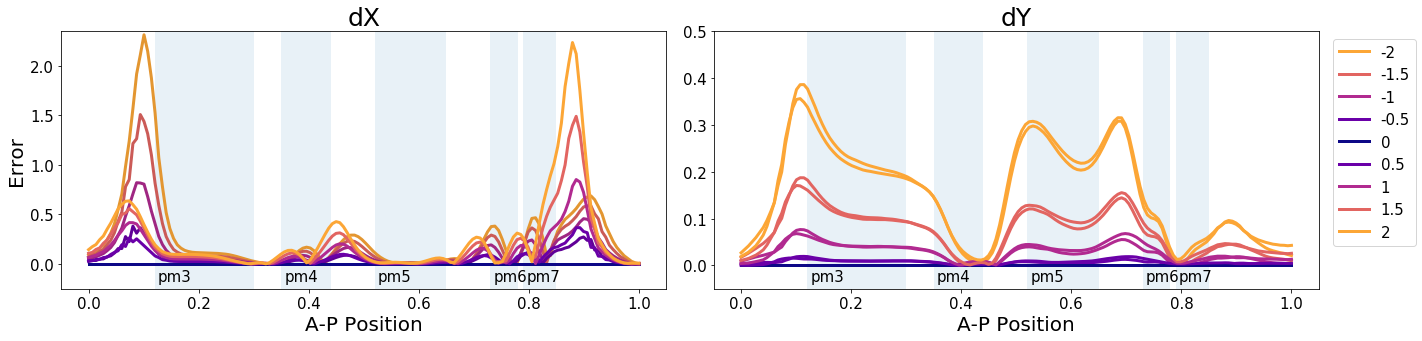

In [450]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
lw = 3

import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap


abs_dx = np.abs(np.array(shift_data.dx))
norm = mpl.colors.Normalize(vmin=np.min(abs_dx), vmax=np.max(abs_dx))
newcmp = ListedColormap(cm.plasma(np.linspace(0, 0.8, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)

xs = np.linspace(0, 1, shift_data.position.size)
for shift in np.unique(shift_data.dx):
    data = shift_data.sel(dx=shift, dy=0, wavelength='r').mean(dim=['experiment', 'pair'])
    color = m.to_rgba(np.abs(shift))
    if shift < 0:
        color = mpl.colors.hsv_to_rgb(
            mpl.colors.rgb_to_hsv(
                color[:-1]
            ) * [1, 1, .9]
        )
    axes[0].plot(
        xs, np.abs(1-data), label='{0:.2g}'.format(shift), linewidth=lw,
        color=color
    )
for shift in np.unique(shift_data.dy):
    data = shift_data.sel(dy=shift, dx=0, wavelength='r').mean(dim=['experiment', 'pair'])
    axes[1].plot(
        xs, np.abs(1-data), label='{0:.2g}'.format(shift), linewidth=lw,
        color=m.to_rgba(np.abs(shift))
    )

axes[0].set_ylim(-0.25, 2.35)
axes[1].set_ylim(-0.05, 0.5)
axes[0].set_ylabel('Error')
axes[0].set_xlabel('A-P Position')
axes[1].set_xlabel('A-P Position')
axes[0].set_title('dX')
axes[1].set_title('dY')

plots.add_regions_to_axis(ax=axes[0],regions=constants.untrimmed_regions)
plots.add_regions_to_axis(ax=axes[1],regions=constants.untrimmed_regions)
    
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")
plt.tight_layout()
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/shift_ratios.pdf', dpi=1200);
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/shift_ratios.png', dpi=300);

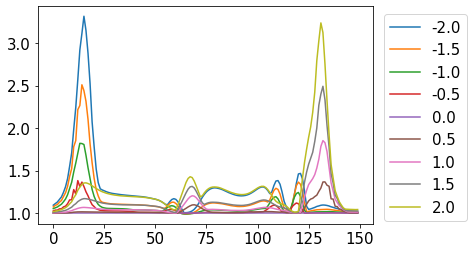

In [454]:
for shift in np.unique(shift_data.dx):
    dX = shift_data.sel(dx=shift, dy=0, wavelength='r').mean(dim=['experiment', 'pair'])
    dY = shift_data.sel(dy=shift, dx=0, wavelength='r').mean(dim=['experiment', 'pair'])
    
    plt.plot(np.maximum(dX, dY), label=shift)

plt.legend(bbox_to_anchor=(1.01,1), loc="upper left")

In [455]:
shift_data.sel(wavelength='r')

<xarray.DataArray (pair: 2, spec: 15534, position: 150)>
array([[[1.188272, 1.220896, ..., 1.021569, 1.070281],
        [1.145833, 1.178674, ..., 1.046185, 1.063872],
        ...,
        [0.925926, 0.918478, ..., 0.971125, 0.954089],
        [0.910364, 0.913514, ..., 0.97856 , 0.972222]],

       [[1.084416, 1.112179, ..., 1.043956, 1.097928],
        [1.073955, 1.101587, ..., 1.071429, 1.073665],
        ...,
        [0.944282, 0.946176, ..., 0.9264  , 0.942857],
        [0.936047, 0.935574, ..., 0.92492 , 0.933962]]])
Coordinates:
  * pair        (pair) int64 0 1
    wavelength  <U3 'r'
  * spec        (spec) MultiIndex
  - experiment  (spec) object '2017_02_22-HD233_SAY47' ... '2019_04_03-ASI_ablation-TODO'
  - dx          (spec) float64 -2.0 -1.5 -1.0 -0.5 0.0 ... 0.0 0.0 0.0 0.0 0.0
  - dy          (spec) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.5 1.0 1.5 2.0
Dimensions without coordinates: position